In [1]:
import os
import cv2 as ocr
import pandas as pd
from os import path
import shutil
from tqdm import tqdm,trange
import sys
import gc
import os
from numpy.random import choice
from itertools import combinations
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import math
from tqdm import tqdm
import keras as K
import matplotlib.pyplot as plt
from collections import Counter
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Activation,BatchNormalization,Lambda, Input, Conv2D, Dense,MaxPooling2D, Dropout, Flatten, UpSampling2D, Reshape

Using TensorFlow backend.


In [2]:
def getNextbatch(batch_size=10, stepNumber=0, imgDim = 128, imageFiles = 'list/of/files', pathSplitIndex = 2, classValLength = 4):
    import cv2 as ocr
    try:
        input_label_list = []
        input_data_list = []
        counter = 0
        start = stepNumber
        end = stepNumber + batch_size

        for imgF in imageFiles[start:end]:
          
            input_label_list.append(int(imgF.split('/')[pathSplitIndex][0:classValLength]))
            input_data_list.append(ocr.imread(imgF,0))

        return (np.array(input_data_list).reshape(-1,imgDim,imgDim,1)
                , np.array(input_label_list).astype('int64'))
    except Exception as e:
        print (e)
        
def getData(dataPath='path/To/Data',channels = 0, pathSplitIndex = 2, classValLength = 4, classCount = None, classValue = None):
    from os import listdir
    from os.path import isfile, join
    
    from tqdm import tqdm
    imageClass = []
    imageFiles = [] 
    input_label_list = []
    input_data_list = []   
    selectedFilePaths = []
    imageFiles = [dataPath+'/'+f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    
    for imgF in tqdm(imageFiles, total=len(imageFiles), unit="files"): 
#         print(imgF)
        c = int(imgF.split('/')[pathSplitIndex][0:classValLength])
        if( classCount!=None and classValue == None):
            imageClass.append(c) 
            if(len(Counter(imageClass).keys())>classCount):
                imageClass[classCount] = imageClass[classCount-1]
            else:
#                 input_label_list.append(c)
#                 input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        elif(classCount==None and classValue!=None):
            if(c in classValue):
#                 input_label_list.append(c)
#                 input_data_list.append(ocr.imread(imgF,channels))
                selectedFilePaths.append(imgF)
        imageClass = list(set(imageClass))
    return np.array(selectedFilePaths)

def contrastive_loss(left_model, right_model, y, margin):
    with tf.name_scope("contrastive-loss"):
        d = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(left_model,right_model), 2), 1, keep_dims=True))
        part1= y * tf.square(d)    
        part2 = (1 - y) * tf.square(tf.maximum((margin - d),0))
        return tf.reduce_mean(part1 + part2) /2
    

images_folder_tr = 'images-32-lfw/'
images_folder_val = images_folder_tr
def gen_random_train_batch(nb_examples):
    out_l,out_r,out_y = [],[],[]
    li = random.sample(range(len(df_train)), nb_examples)
    for i in li:
        im_l = df_train.iloc[i]['name1']+"/"+df_train.iloc[i]['name1']+'_'+str(df_train.iloc[i]['im1']).zfill(4)+".jpg"
        im_r = df_train.iloc[i]['name2']+"/"+df_train.iloc[i]['name2']+'_'+str(df_train.iloc[i]['im2']).zfill(4)+".jpg"
        
        
        out_l.append(ocr.imread(images_folder_tr+im_l,0))
        out_r.append(ocr.imread(images_folder_tr+im_r,0))
        out_y.append(df_train.iloc[i]['label'])
    out_l = ((np.array(out_l))/255.0).astype('float32')
    out_r = ((np.array(out_r))/255.0).astype('float32')
    out_y = np.array(out_y).reshape((-1,1))
    return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1), np.array(out_y)

def gen_random_val_batch(nb_examples):
    out_l,out_r,out_y = [],[],[]
    li = random.sample(range(len(df_val)), nb_examples)
    for i in li:
        
        im_l = df_val.iloc[i]['name1']+"/"+df_val.iloc[i]['name1']+'_'+str(df_val.iloc[i]['im1']).zfill(4)+".jpg"
        im_r = df_val.iloc[i]['name2']+"/"+df_val.iloc[i]['name2']+'_'+str(df_val.iloc[i]['im2']).zfill(4)+".jpg"
        
        
        out_l.append(ocr.imread(images_folder_val+im_l,0))
        out_r.append(ocr.imread(images_folder_val+im_r,0))
        out_y.append(df_val.iloc[i]['label'])
    out_l = ((np.array(out_l))/255.0).astype('float32')
    out_r = ((np.array(out_r))/255.0).astype('float32')
    out_y = np.array(out_y).reshape((-1,1))
    return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1), np.array(out_y)

# def gen_random_train_batch_sift(nb_examples):
#     out_l,out_r,sift_l,sift_r,out_y = [],[],[],[],[]
#     li = random.sample(range(len(df_train)), nb_examples)
#     for i in li:
#         out_l.append(ocr.imread(images_folder_tr+df_train.iloc[i]['left'],0))
#         out_r.append(ocr.imread(images_folder_tr+df_train.iloc[i]['right'],0))
#         sift_l.append(df_train.iloc[i][3:259])
#         sift_r.append(df_train.iloc[i][259:])
#         out_y.append(df_train.iloc[i]['label'])
#     out_l = ((255.01 - np.array(out_l))/255.0).astype('float32')
#     out_r = ((255.01 - np.array(out_r))/255.0).astype('float32')
#     sift_l = np.array(sift_l).reshape((-1,256))
#     sift_r = np.array(sift_r).reshape((-1,256))
#     out_y = np.array(out_y).reshape((-1,1))
#     return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1),sift_l,sift_r, out_y

# def gen_random_val_batch_sift(nb_examples):
#     out_l,out_r,sift_l,sift_r,out_y = [],[],[],[],[]
#     li = random.sample(range(len(df_val)), nb_examples)
#     for i in li:
#         out_l.append(ocr.imread(images_folder_val+df_val.iloc[i]['left'],0))
#         out_r.append(ocr.imread(images_folder_val+df_val.iloc[i]['right'],0))
#         sift_l.append(df_val.iloc[i][3:259])
#         sift_r.append(df_val.iloc[i][259:])
#         out_y.append(df_val.iloc[i]['label'])
#     out_l = ((255.01 - np.array(out_l))/255.0).astype('float32')
#     out_r = ((255.01 - np.array(out_r))/255.0).astype('float32')
#     sift_l = np.array(sift_l).reshape((-1,256))
#     sift_r = np.array(sift_r).reshape((-1,256))
#     out_y = np.array(out_y).reshape((-1,1))
#     return out_l.reshape(-1,imDim,imDim,1), out_r.reshape(-1,imDim,imDim,1),sift_l,sift_r, out_y


In [3]:
# from itertools import combinations
# def generateDatasetAndSave_Siamese():
#     label = []
#     left_path = []
#     right_path = []
#     simCounter = 0
#     for l,r in combinations(train_files_list,2):
#         if(int(l.split('/')[3][:4]) == int(r.split('/')[3][:4])):
#             label.append([1])
#     #     else:
#     #         label.append([0,1])
#             left_path.append(l)
#             right_path.append(r)
#             simCounter+=1
#     diffCounter = 0
#     for l,r in combinations(train_files_list,2):
#         if(int(l.split('/')[3][:4]) != int(r.split('/')[3][:4])):
#             label.append([0])
#     #     else:
#     #         label.append([0,1])
#             left_path.append(l)
#             right_path.append(r)
#             diffCounter+=1
#         if(diffCounter==simCounter):
#             break
#     df = pd.DataFrame()
#     pd.options.display.max_colwidth = 100
#     df['left'] = left_path
#     df['right'] = right_path
#     df['label'] = label
#     df.to_csv('dataset_training_siamese.csv')

### Sets params

In [4]:
imDim = 32
mode = 'concat'
nb_epochs = 

### Create Feature extracter model

In [5]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9

set_session(tf.Session(config=config))

input_shape  = (imDim,imDim,1)
inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
model = inp_img

#     model = Input(shape=(imDim,imDim,1))
#     model.add(Input(shape = (imDim,imDim,1), name = 'FeatureNet_ImageInput'))
model = Conv2D(64,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same')(model)
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model = MaxPooling2D((2,2), padding='valid')(model)
model = Conv2D(128, (3, 3), activation='relu',padding='same')(model)
#     model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model = MaxPooling2D((2,2),padding='valid')(model)
model = Dropout(0.1)(model)
#     model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
model = Conv2D(256, (3, 3), activation='relu',padding='same')(model)
model = MaxPooling2D((2,2),padding='valid')(model)
#     model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
#     model.add(Conv2D(2, (3, 3), activation='relu',padding='same'))
model = Dropout(0.1)(model)
model = Conv2D(128, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)
model = Dropout(0.1)(model)
model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Flatten()(model)

# img_in = np.array((-1,imDim,imDim,1), dtype='float32')
# img_in = tf.placeholder(shape=(imDim,imDim,1), dtype='float32')

feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
feat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
__________

In [6]:
left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
right_img = Input(shape = (imDim,imDim,1), name = 'right_img')
# left_sift = Input(shape= (256,), name = 'left_sift')
# right_sift = Input(shape= (256,), name = 'right_sift')

In [7]:
left_feats = feat(left_img)
right_feats = feat(right_img)

# inpTensor = Input((1,256,), name = 'SIFTInput')
# finalOut = Flatten()(inpTensor)  
# sift_model = Model(inputs=[inpTensor], outputs=[finalOut], name='Sift_Model')
# sift_model.summary()

# left_sift_feats = sift_model(left_sift)
# right_sift_feats = sift_model(right_sift)
# print(left_sift_feats)
print(left_feats)

Tensor("Feat_Model/flatten_1/Reshape:0", shape=(?, ?), dtype=float32)


In [8]:
from keras.layers import concatenate, subtract, multiply, division
from keras.utils import to_categorical
import random  

In [9]:

## CNN+SIFT
# merged_feats = concatenate([left_feats, right_feats, left_sift_feats, right_sift_feats], name = 'merged_feats')
## Only SIFT merge
# merged_feats = concatenate([left_sift_feats, right_sift_feats], name = 'merged_feats')
## Only CNN merge
if mode == 'concat':
    merged_feats = concatenate([left_feats, right_feats], name = 'merged_feats')
elif mode == 'subtract':
    merged_feats = subtract([left_feats, right_feats], name = 'merged_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dropout(0.1)(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dropout(0.1)(merged_feats)
merged_feats = Dense(2, activation = 'softmax')(merged_feats)
## only sift
# similarity_model = Model(inputs = [left_sift,right_sift], outputs = [merged_feats], name = 'Similarity_Model')
## only cnn
similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
## with cnn+sift
# similarity_model = Model(inputs = [left_img, right_img, left_sift,right_sift], outputs = [merged_feats], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
Feat_Model (Model)              (None, 64)           410816      left_img[0][0]                   
                                                                 right_img[0][0]                  
__________________________________________________________________________________________________
merged_feats (Concatenate)      (None, 128)          0           Feat_Model[1][0]                 
          

In [10]:
main_folder = ''
sgd = K.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# similarity_model.load_weights('weights/weights-siamese-AND-concat-cnn-0.377613.hdf5')

In [11]:
train_set = 'pairsDevTrain.csv'
val_set = 'pairsDevTest.csv'
df_train = pd.DataFrame.from_csv(train_set).reset_index()
df_val = pd.DataFrame.from_csv(val_set).reset_index()
df_train.shape[0]


2200

In [12]:
df_val.shape[0]

1000

In [13]:
# iteration = 0
# left_image = ocr.imread(df.iloc[iteration]['left'],0)
# right_image = ocr.imread(df.iloc[iteration]['right'],0)
# y = df.iloc[iteration]['label']


In [14]:
n_epochs = 10000
batch_size = 64
imgDim =  imDim
best_loss_tr = np.infty
max_val_acc = 0
train_files_list = df_train.shape[0]
train_num_examples = train_files_list
print('Train on: %2d, Validate on: %2d' %(train_num_examples, df_val.shape[0]))
n_iterations_per_epoch = train_num_examples // batch_size
# n_iterations_validation = val_num_examples // batch_size
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.0
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_loss_vals = []
tr_acc_vals = []
val_acc_vals = []
v_batch_size = df_val.shape[0]
early_stopping_counter = 0
patience = 100


batch_metrics = None
batch_metric_loss = []
batch_metric_acc = []
for epoch in range(n_epochs):
    for iteration in range(int(train_files_list/batch_size)):        
        left_image, right_image, y = gen_random_train_batch(batch_size)
        y = to_categorical(y)
#         print('\n------\n'+str(y)+'\n------\n')
        left_image = left_image.reshape((-1, imgDim, imgDim, 1))
        right_image = right_image.reshape((-1, imgDim, imgDim, 1))
#         batch_metrics = similarity_model.train_on_batch([left_image,right_image,sift_l,sift_r],[y])
#         batch_metrics = similarity_model.train_on_batch([sift_l,sift_r],[y])
        batch_metrics = similarity_model.train_on_batch([left_image,right_image],[y])
        
        batch_metric_loss.append(batch_metrics[0])
        batch_metric_acc.append(batch_metrics[1])
        print("\rTraining the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_per_epoch,
                  iteration * 100 / n_iterations_per_epoch),
              end="" * 10)
    loss_tr = np.mean(batch_metric_loss)
    acc_tr = np.mean(batch_metric_acc)
    tr_loss_vals.append(loss_tr)
    tr_acc_vals.append(acc_tr)
    
    v_left_image ,v_right_image, v_y = gen_random_val_batch(v_batch_size)
    
#     pred_sim = similarity_model.predict([v_left_image ,v_right_image,v_sift_l, v_sift_r])
#     pred_sim = similarity_model.predict([v_sift_l, v_sift_r])
    pred_sim = similarity_model.predict([v_left_image ,v_right_image])
    pred_val_sim = []
    for p in pred_sim:
        pred_val_sim.append(np.argmax(p))
    v_acc = float((np.array(pred_val_sim).reshape((v_batch_size,1))==v_y).sum())/float(len(v_y))
    val_acc_vals.append(v_acc)
    
    print("\rEpoch: {}  Train accuracy: {:.4f}%, Tr Loss: {:.4f}, Validation acc: {:.2f}% {}".format(
        epoch + 1
        , (acc_tr) * 100
        , loss_tr
        , (v_acc)*100.0,
        " (improved)" if v_acc > max_val_acc else ""))
    if loss_tr < best_loss_tr:
        best_loss_tr = loss_tr        
    if max_val_acc < v_acc:
        max_val_acc = v_acc
        early_stopping_counter = 0
        filepath='weights/siam-'+str(imgDim)+'-cnn-'+mode+'-[val-acc-'+str(v_acc)+'].hdf5'
        similarity_model.save(filepath)
    else:
        early_stopping_counter+=1
#     if early_stopping_counter==patience:
#         print('early stopped - no increase in val acc over previous '+str(patience)+' epochs')
#         break


Train on: 2200, Validate on: 1000
Epoch: 1  Train accuracy: 50.1379%, Tr Loss: 0.7075, Validation acc: 50.00%  (improved)
Epoch: 2  Train accuracy: 49.6324%, Tr Loss: 0.7026, Validation acc: 50.00% 
Epoch: 3  Train accuracy: 50.4442%, Tr Loss: 0.6989, Validation acc: 50.00% 
Epoch: 4  Train accuracy: 50.5974%, Tr Loss: 0.6977, Validation acc: 50.00% 
Epoch: 5  Train accuracy: 50.8915%, Tr Loss: 0.6965, Validation acc: 50.00% 
Epoch: 6  Train accuracy: 51.1872%, Tr Loss: 0.6954, Validation acc: 50.00% 
Epoch: 7  Train accuracy: 51.1292%, Tr Loss: 0.6948, Validation acc: 50.90%  (improved)
Epoch: 8  Train accuracy: 51.1546%, Tr Loss: 0.6945, Validation acc: 50.00% 
Epoch: 9  Train accuracy: 51.3378%, Tr Loss: 0.6940, Validation acc: 51.80%  (improved)
Epoch: 10  Train accuracy: 51.4154%, Tr Loss: 0.6937, Validation acc: 50.90% 
Epoch: 11  Train accuracy: 51.4873%, Tr Loss: 0.6935, Validation acc: 51.40% 
Epoch: 12  Train accuracy: 51.5204%, Tr Loss: 0.6935, Validation acc: 51.60% 
Epoch:

Epoch: 103  Train accuracy: 57.6157%, Tr Loss: 0.6630, Validation acc: 57.40% 
Epoch: 104  Train accuracy: 57.7595%, Tr Loss: 0.6617, Validation acc: 58.80% 
Epoch: 105  Train accuracy: 57.9132%, Tr Loss: 0.6603, Validation acc: 56.50% 
Epoch: 106  Train accuracy: 58.0761%, Tr Loss: 0.6586, Validation acc: 58.00% 
Epoch: 107  Train accuracy: 58.2338%, Tr Loss: 0.6571, Validation acc: 57.00% 
Epoch: 108  Train accuracy: 58.3976%, Tr Loss: 0.6555, Validation acc: 57.80% 
Epoch: 109  Train accuracy: 58.5461%, Tr Loss: 0.6540, Validation acc: 58.50% 
Epoch: 110  Train accuracy: 58.7040%, Tr Loss: 0.6524, Validation acc: 58.10% 
Epoch: 111  Train accuracy: 58.8753%, Tr Loss: 0.6506, Validation acc: 59.20% 
Epoch: 112  Train accuracy: 59.0451%, Tr Loss: 0.6487, Validation acc: 59.50% 
Epoch: 113  Train accuracy: 59.2257%, Tr Loss: 0.6468, Validation acc: 56.60% 
Epoch: 114  Train accuracy: 59.4036%, Tr Loss: 0.6449, Validation acc: 58.70% 
Epoch: 115  Train accuracy: 59.5800%, Tr Loss: 0.643

Epoch: 206  Train accuracy: 74.0492%, Tr Loss: 0.4391, Validation acc: 57.70% 
Epoch: 207  Train accuracy: 74.1632%, Tr Loss: 0.4373, Validation acc: 57.40% 
Epoch: 208  Train accuracy: 74.2729%, Tr Loss: 0.4355, Validation acc: 59.90% 
Epoch: 209  Train accuracy: 74.3870%, Tr Loss: 0.4337, Validation acc: 57.80% 
Epoch: 210  Train accuracy: 74.4978%, Tr Loss: 0.4319, Validation acc: 57.50% 
Epoch: 211  Train accuracy: 74.6090%, Tr Loss: 0.4301, Validation acc: 58.10% 
Epoch: 212  Train accuracy: 74.7175%, Tr Loss: 0.4284, Validation acc: 60.10% 
Epoch: 213  Train accuracy: 74.8246%, Tr Loss: 0.4267, Validation acc: 56.60% 
Epoch: 214  Train accuracy: 74.9313%, Tr Loss: 0.4250, Validation acc: 57.50% 
Epoch: 215  Train accuracy: 75.0380%, Tr Loss: 0.4233, Validation acc: 60.00% 
Epoch: 216  Train accuracy: 75.1383%, Tr Loss: 0.4217, Validation acc: 57.40% 
Epoch: 217  Train accuracy: 75.2368%, Tr Loss: 0.4201, Validation acc: 57.70% 
Epoch: 218  Train accuracy: 75.3383%, Tr Loss: 0.418

Epoch: 309  Train accuracy: 82.0837%, Tr Loss: 0.3084, Validation acc: 59.00% 
Epoch: 310  Train accuracy: 82.1361%, Tr Loss: 0.3075, Validation acc: 59.10% 
Epoch: 311  Train accuracy: 82.1895%, Tr Loss: 0.3066, Validation acc: 58.70% 
Epoch: 312  Train accuracy: 82.2439%, Tr Loss: 0.3057, Validation acc: 58.00% 
Epoch: 313  Train accuracy: 82.2966%, Tr Loss: 0.3048, Validation acc: 58.60% 
Epoch: 314  Train accuracy: 82.3494%, Tr Loss: 0.3040, Validation acc: 58.70% 
Epoch: 315  Train accuracy: 82.4009%, Tr Loss: 0.3031, Validation acc: 56.50% 
Epoch: 316  Train accuracy: 82.4530%, Tr Loss: 0.3022, Validation acc: 57.80% 
Epoch: 317  Train accuracy: 82.5046%, Tr Loss: 0.3014, Validation acc: 61.00% 
Epoch: 318  Train accuracy: 82.5548%, Tr Loss: 0.3005, Validation acc: 59.20% 
Epoch: 319  Train accuracy: 82.6053%, Tr Loss: 0.2997, Validation acc: 58.90% 
Epoch: 320  Train accuracy: 82.6552%, Tr Loss: 0.2988, Validation acc: 60.80% 
Epoch: 321  Train accuracy: 82.7060%, Tr Loss: 0.298

Epoch: 412  Train accuracy: 86.2614%, Tr Loss: 0.2383, Validation acc: 59.00% 
Epoch: 413  Train accuracy: 86.2925%, Tr Loss: 0.2378, Validation acc: 58.80% 
Epoch: 414  Train accuracy: 86.3240%, Tr Loss: 0.2373, Validation acc: 58.70% 
Epoch: 415  Train accuracy: 86.3551%, Tr Loss: 0.2367, Validation acc: 58.40% 
Epoch: 416  Train accuracy: 86.3855%, Tr Loss: 0.2362, Validation acc: 59.50% 
Epoch: 417  Train accuracy: 86.4157%, Tr Loss: 0.2357, Validation acc: 59.40% 
Epoch: 418  Train accuracy: 86.4460%, Tr Loss: 0.2352, Validation acc: 57.50% 
Epoch: 419  Train accuracy: 86.4761%, Tr Loss: 0.2347, Validation acc: 58.30% 
Epoch: 420  Train accuracy: 86.5058%, Tr Loss: 0.2342, Validation acc: 58.80% 
Epoch: 421  Train accuracy: 86.5361%, Tr Loss: 0.2337, Validation acc: 59.10% 
Epoch: 422  Train accuracy: 86.5657%, Tr Loss: 0.2332, Validation acc: 58.60% 
Epoch: 423  Train accuracy: 86.5950%, Tr Loss: 0.2327, Validation acc: 58.50% 
Epoch: 424  Train accuracy: 86.6237%, Tr Loss: 0.232

Epoch: 515  Train accuracy: 88.8178%, Tr Loss: 0.1948, Validation acc: 58.50% 
Epoch: 516  Train accuracy: 88.8384%, Tr Loss: 0.1945, Validation acc: 59.50% 
Epoch: 517  Train accuracy: 88.8583%, Tr Loss: 0.1941, Validation acc: 58.30% 
Epoch: 518  Train accuracy: 88.8783%, Tr Loss: 0.1938, Validation acc: 57.80% 
Epoch: 519  Train accuracy: 88.8969%, Tr Loss: 0.1935, Validation acc: 58.20% 
Epoch: 520  Train accuracy: 88.9162%, Tr Loss: 0.1931, Validation acc: 58.60% 
Epoch: 521  Train accuracy: 88.9355%, Tr Loss: 0.1928, Validation acc: 58.80% 
Epoch: 522  Train accuracy: 88.9554%, Tr Loss: 0.1925, Validation acc: 59.30% 
Epoch: 523  Train accuracy: 88.9749%, Tr Loss: 0.1921, Validation acc: 60.30% 
Epoch: 524  Train accuracy: 88.9948%, Tr Loss: 0.1918, Validation acc: 59.30% 
Epoch: 525  Train accuracy: 89.0148%, Tr Loss: 0.1915, Validation acc: 60.30% 
Epoch: 526  Train accuracy: 89.0337%, Tr Loss: 0.1911, Validation acc: 60.30% 
Epoch: 527  Train accuracy: 89.0527%, Tr Loss: 0.190

Epoch: 618  Train accuracy: 90.5408%, Tr Loss: 0.1652, Validation acc: 58.40% 
Epoch: 619  Train accuracy: 90.5542%, Tr Loss: 0.1650, Validation acc: 55.50% 
Epoch: 620  Train accuracy: 90.5685%, Tr Loss: 0.1648, Validation acc: 57.20% 
Epoch: 621  Train accuracy: 90.5822%, Tr Loss: 0.1645, Validation acc: 59.00% 
Epoch: 622  Train accuracy: 90.5962%, Tr Loss: 0.1643, Validation acc: 57.90% 
Epoch: 623  Train accuracy: 90.6101%, Tr Loss: 0.1641, Validation acc: 58.40% 
Epoch: 624  Train accuracy: 90.6242%, Tr Loss: 0.1638, Validation acc: 57.90% 
Epoch: 625  Train accuracy: 90.6382%, Tr Loss: 0.1636, Validation acc: 58.90% 
Epoch: 626  Train accuracy: 90.6519%, Tr Loss: 0.1633, Validation acc: 58.70% 
Epoch: 627  Train accuracy: 90.6655%, Tr Loss: 0.1631, Validation acc: 58.50% 
Epoch: 628  Train accuracy: 90.6784%, Tr Loss: 0.1629, Validation acc: 59.20% 
Epoch: 629  Train accuracy: 90.6919%, Tr Loss: 0.1627, Validation acc: 56.70% 
Epoch: 630  Train accuracy: 90.7052%, Tr Loss: 0.162

Epoch: 721  Train accuracy: 91.7824%, Tr Loss: 0.1439, Validation acc: 57.80% 
Epoch: 722  Train accuracy: 91.7931%, Tr Loss: 0.1437, Validation acc: 58.50% 
Epoch: 723  Train accuracy: 91.8040%, Tr Loss: 0.1435, Validation acc: 59.90% 
Epoch: 724  Train accuracy: 91.8143%, Tr Loss: 0.1433, Validation acc: 58.80% 
Epoch: 725  Train accuracy: 91.8245%, Tr Loss: 0.1431, Validation acc: 58.20% 
Epoch: 726  Train accuracy: 91.8352%, Tr Loss: 0.1429, Validation acc: 57.40% 
Epoch: 727  Train accuracy: 91.8448%, Tr Loss: 0.1428, Validation acc: 59.50% 
Epoch: 728  Train accuracy: 91.8548%, Tr Loss: 0.1426, Validation acc: 58.80% 
Epoch: 729  Train accuracy: 91.8652%, Tr Loss: 0.1424, Validation acc: 58.10% 
Epoch: 730  Train accuracy: 91.8756%, Tr Loss: 0.1423, Validation acc: 58.10% 
Epoch: 731  Train accuracy: 91.8857%, Tr Loss: 0.1421, Validation acc: 57.20% 
Epoch: 732  Train accuracy: 91.8959%, Tr Loss: 0.1419, Validation acc: 57.70% 
Epoch: 733  Train accuracy: 91.9059%, Tr Loss: 0.141

Epoch: 824  Train accuracy: 92.7289%, Tr Loss: 0.1275, Validation acc: 59.20% 
Epoch: 825  Train accuracy: 92.7368%, Tr Loss: 0.1273, Validation acc: 59.20% 
Epoch: 826  Train accuracy: 92.7446%, Tr Loss: 0.1272, Validation acc: 58.60% 
Epoch: 827  Train accuracy: 92.7526%, Tr Loss: 0.1271, Validation acc: 56.40% 
Epoch: 828  Train accuracy: 92.7607%, Tr Loss: 0.1269, Validation acc: 58.50% 
Epoch: 829  Train accuracy: 92.7685%, Tr Loss: 0.1268, Validation acc: 56.90% 
Epoch: 830  Train accuracy: 92.7761%, Tr Loss: 0.1267, Validation acc: 59.30% 
Epoch: 831  Train accuracy: 92.7839%, Tr Loss: 0.1265, Validation acc: 56.80% 
Epoch: 832  Train accuracy: 92.7920%, Tr Loss: 0.1264, Validation acc: 59.40% 
Epoch: 833  Train accuracy: 92.7995%, Tr Loss: 0.1263, Validation acc: 58.90% 
Epoch: 834  Train accuracy: 92.8071%, Tr Loss: 0.1261, Validation acc: 59.70% 
Epoch: 835  Train accuracy: 92.8145%, Tr Loss: 0.1260, Validation acc: 58.60% 
Epoch: 836  Train accuracy: 92.8222%, Tr Loss: 0.125

Epoch: 927  Train accuracy: 93.4610%, Tr Loss: 0.1147, Validation acc: 60.40% 
Epoch: 928  Train accuracy: 93.4672%, Tr Loss: 0.1146, Validation acc: 60.00% 
Epoch: 929  Train accuracy: 93.4732%, Tr Loss: 0.1145, Validation acc: 58.50% 
Epoch: 930  Train accuracy: 93.4795%, Tr Loss: 0.1144, Validation acc: 59.20% 
Epoch: 931  Train accuracy: 93.4859%, Tr Loss: 0.1143, Validation acc: 60.30% 
Epoch: 932  Train accuracy: 93.4924%, Tr Loss: 0.1142, Validation acc: 60.00% 
Epoch: 933  Train accuracy: 93.4987%, Tr Loss: 0.1141, Validation acc: 58.00% 
Epoch: 934  Train accuracy: 93.5049%, Tr Loss: 0.1140, Validation acc: 58.00% 
Epoch: 935  Train accuracy: 93.5108%, Tr Loss: 0.1139, Validation acc: 58.90% 
Epoch: 936  Train accuracy: 93.5170%, Tr Loss: 0.1137, Validation acc: 59.60% 
Epoch: 937  Train accuracy: 93.5231%, Tr Loss: 0.1136, Validation acc: 59.80% 
Epoch: 938  Train accuracy: 93.5292%, Tr Loss: 0.1135, Validation acc: 58.60% 
Epoch: 939  Train accuracy: 93.5354%, Tr Loss: 0.113

Epoch: 1030  Train accuracy: 94.0480%, Tr Loss: 0.1045, Validation acc: 60.30% 
Epoch: 1031  Train accuracy: 94.0532%, Tr Loss: 0.1044, Validation acc: 59.10% 
Epoch: 1032  Train accuracy: 94.0581%, Tr Loss: 0.1043, Validation acc: 60.30% 
Epoch: 1033  Train accuracy: 94.0633%, Tr Loss: 0.1042, Validation acc: 58.50% 
Epoch: 1034  Train accuracy: 94.0688%, Tr Loss: 0.1041, Validation acc: 59.00% 
Epoch: 1035  Train accuracy: 94.0737%, Tr Loss: 0.1041, Validation acc: 58.90% 
Epoch: 1036  Train accuracy: 94.0790%, Tr Loss: 0.1040, Validation acc: 59.50% 
Epoch: 1037  Train accuracy: 94.0841%, Tr Loss: 0.1039, Validation acc: 59.00% 
Epoch: 1038  Train accuracy: 94.0893%, Tr Loss: 0.1038, Validation acc: 59.10% 
Epoch: 1039  Train accuracy: 94.0944%, Tr Loss: 0.1037, Validation acc: 59.50% 
Epoch: 1040  Train accuracy: 94.0997%, Tr Loss: 0.1036, Validation acc: 59.60% 
Epoch: 1041  Train accuracy: 94.1045%, Tr Loss: 0.1035, Validation acc: 57.60% 
Epoch: 1042  Train accuracy: 94.1097%, T

Epoch: 1132  Train accuracy: 94.5278%, Tr Loss: 0.0961, Validation acc: 56.60% 
Epoch: 1133  Train accuracy: 94.5322%, Tr Loss: 0.0960, Validation acc: 59.10% 
Epoch: 1134  Train accuracy: 94.5364%, Tr Loss: 0.0960, Validation acc: 58.70% 
Epoch: 1135  Train accuracy: 94.5406%, Tr Loss: 0.0959, Validation acc: 58.40% 
Epoch: 1136  Train accuracy: 94.5449%, Tr Loss: 0.0958, Validation acc: 56.80% 
Epoch: 1137  Train accuracy: 94.5493%, Tr Loss: 0.0957, Validation acc: 59.30% 
Epoch: 1138  Train accuracy: 94.5537%, Tr Loss: 0.0957, Validation acc: 60.50% 
Epoch: 1139  Train accuracy: 94.5578%, Tr Loss: 0.0956, Validation acc: 59.00% 
Epoch: 1140  Train accuracy: 94.5620%, Tr Loss: 0.0955, Validation acc: 59.70% 
Epoch: 1141  Train accuracy: 94.5659%, Tr Loss: 0.0954, Validation acc: 59.80% 
Epoch: 1142  Train accuracy: 94.5698%, Tr Loss: 0.0954, Validation acc: 60.30% 
Epoch: 1143  Train accuracy: 94.5740%, Tr Loss: 0.0953, Validation acc: 58.40% 
Epoch: 1144  Train accuracy: 94.5783%, T

Epoch: 1234  Train accuracy: 94.9284%, Tr Loss: 0.0891, Validation acc: 58.90% 
Epoch: 1235  Train accuracy: 94.9320%, Tr Loss: 0.0890, Validation acc: 60.60% 
Epoch: 1236  Train accuracy: 94.9355%, Tr Loss: 0.0890, Validation acc: 60.80% 
Epoch: 1237  Train accuracy: 94.9391%, Tr Loss: 0.0889, Validation acc: 58.70% 
Epoch: 1238  Train accuracy: 94.9427%, Tr Loss: 0.0888, Validation acc: 59.20% 
Epoch: 1239  Train accuracy: 94.9465%, Tr Loss: 0.0888, Validation acc: 59.00% 
Epoch: 1240  Train accuracy: 94.9501%, Tr Loss: 0.0887, Validation acc: 61.20% 
Epoch: 1241  Train accuracy: 94.9535%, Tr Loss: 0.0886, Validation acc: 60.20% 
Epoch: 1242  Train accuracy: 94.9571%, Tr Loss: 0.0886, Validation acc: 59.90% 
Epoch: 1243  Train accuracy: 94.9606%, Tr Loss: 0.0885, Validation acc: 58.80% 
Epoch: 1244  Train accuracy: 94.9641%, Tr Loss: 0.0885, Validation acc: 59.30% 
Epoch: 1245  Train accuracy: 94.9676%, Tr Loss: 0.0884, Validation acc: 56.60% 
Epoch: 1246  Train accuracy: 94.9711%, T

Epoch: 1336  Train accuracy: 95.2682%, Tr Loss: 0.0831, Validation acc: 60.10% 
Epoch: 1337  Train accuracy: 95.2711%, Tr Loss: 0.0830, Validation acc: 59.50% 
Epoch: 1338  Train accuracy: 95.2742%, Tr Loss: 0.0830, Validation acc: 60.40% 
Epoch: 1339  Train accuracy: 95.2773%, Tr Loss: 0.0829, Validation acc: 60.70% 
Epoch: 1340  Train accuracy: 95.2805%, Tr Loss: 0.0829, Validation acc: 60.40% 
Epoch: 1341  Train accuracy: 95.2836%, Tr Loss: 0.0828, Validation acc: 59.40% 
Epoch: 1342  Train accuracy: 95.2863%, Tr Loss: 0.0828, Validation acc: 59.00% 
Epoch: 1343  Train accuracy: 95.2895%, Tr Loss: 0.0827, Validation acc: 59.60% 
Epoch: 1344  Train accuracy: 95.2926%, Tr Loss: 0.0827, Validation acc: 59.60% 
Epoch: 1345  Train accuracy: 95.2957%, Tr Loss: 0.0826, Validation acc: 59.90% 
Epoch: 1346  Train accuracy: 95.2986%, Tr Loss: 0.0826, Validation acc: 59.70% 
Epoch: 1347  Train accuracy: 95.3017%, Tr Loss: 0.0825, Validation acc: 60.00% 
Epoch: 1348  Train accuracy: 95.3047%, T

Epoch: 1438  Train accuracy: 95.5620%, Tr Loss: 0.0779, Validation acc: 60.40% 
Epoch: 1439  Train accuracy: 95.5646%, Tr Loss: 0.0779, Validation acc: 60.30% 
Epoch: 1440  Train accuracy: 95.5672%, Tr Loss: 0.0778, Validation acc: 59.30% 
Epoch: 1441  Train accuracy: 95.5700%, Tr Loss: 0.0778, Validation acc: 59.20% 
Epoch: 1442  Train accuracy: 95.5726%, Tr Loss: 0.0777, Validation acc: 58.40% 
Epoch: 1443  Train accuracy: 95.5752%, Tr Loss: 0.0777, Validation acc: 57.40% 
Epoch: 1444  Train accuracy: 95.5777%, Tr Loss: 0.0776, Validation acc: 57.40% 
Epoch: 1445  Train accuracy: 95.5802%, Tr Loss: 0.0776, Validation acc: 57.20% 
Epoch: 1446  Train accuracy: 95.5830%, Tr Loss: 0.0775, Validation acc: 57.30% 
Epoch: 1447  Train accuracy: 95.5857%, Tr Loss: 0.0775, Validation acc: 57.50% 
Epoch: 1448  Train accuracy: 95.5886%, Tr Loss: 0.0774, Validation acc: 56.90% 
Epoch: 1449  Train accuracy: 95.5913%, Tr Loss: 0.0774, Validation acc: 57.50% 
Epoch: 1450  Train accuracy: 95.5940%, T

Epoch: 1540  Train accuracy: 95.8165%, Tr Loss: 0.0734, Validation acc: 59.90% 
Epoch: 1541  Train accuracy: 95.8188%, Tr Loss: 0.0734, Validation acc: 60.10% 
Epoch: 1542  Train accuracy: 95.8211%, Tr Loss: 0.0733, Validation acc: 61.90% 
Epoch: 1543  Train accuracy: 95.8233%, Tr Loss: 0.0733, Validation acc: 59.30% 
Epoch: 1544  Train accuracy: 95.8258%, Tr Loss: 0.0732, Validation acc: 59.70% 
Epoch: 1545  Train accuracy: 95.8281%, Tr Loss: 0.0732, Validation acc: 60.60% 
Epoch: 1546  Train accuracy: 95.8304%, Tr Loss: 0.0732, Validation acc: 59.80% 
Epoch: 1547  Train accuracy: 95.8330%, Tr Loss: 0.0731, Validation acc: 59.90% 
Epoch: 1548  Train accuracy: 95.8351%, Tr Loss: 0.0731, Validation acc: 59.40% 
Epoch: 1549  Train accuracy: 95.8375%, Tr Loss: 0.0730, Validation acc: 59.60% 
Epoch: 1550  Train accuracy: 95.8396%, Tr Loss: 0.0730, Validation acc: 56.40% 
Epoch: 1551  Train accuracy: 95.8419%, Tr Loss: 0.0730, Validation acc: 57.80% 
Epoch: 1552  Train accuracy: 95.8441%, T

Epoch: 1642  Train accuracy: 96.0388%, Tr Loss: 0.0695, Validation acc: 59.20% 
Epoch: 1643  Train accuracy: 96.0408%, Tr Loss: 0.0695, Validation acc: 59.10% 
Epoch: 1644  Train accuracy: 96.0426%, Tr Loss: 0.0695, Validation acc: 58.80% 
Epoch: 1645  Train accuracy: 96.0445%, Tr Loss: 0.0694, Validation acc: 58.90% 
Epoch: 1646  Train accuracy: 96.0465%, Tr Loss: 0.0694, Validation acc: 59.50% 
Epoch: 1647  Train accuracy: 96.0486%, Tr Loss: 0.0694, Validation acc: 58.90% 
Epoch: 1648  Train accuracy: 96.0504%, Tr Loss: 0.0693, Validation acc: 59.20% 
Epoch: 1649  Train accuracy: 96.0525%, Tr Loss: 0.0693, Validation acc: 59.40% 
Epoch: 1650  Train accuracy: 96.0543%, Tr Loss: 0.0693, Validation acc: 59.70% 
Epoch: 1651  Train accuracy: 96.0563%, Tr Loss: 0.0692, Validation acc: 59.80% 
Epoch: 1652  Train accuracy: 96.0585%, Tr Loss: 0.0692, Validation acc: 59.80% 
Epoch: 1653  Train accuracy: 96.0606%, Tr Loss: 0.0691, Validation acc: 60.00% 
Epoch: 1654  Train accuracy: 96.0627%, T

Epoch: 1744  Train accuracy: 96.2371%, Tr Loss: 0.0660, Validation acc: 60.80% 
Epoch: 1745  Train accuracy: 96.2391%, Tr Loss: 0.0660, Validation acc: 60.30% 
Epoch: 1746  Train accuracy: 96.2410%, Tr Loss: 0.0660, Validation acc: 60.70% 
Epoch: 1747  Train accuracy: 96.2429%, Tr Loss: 0.0659, Validation acc: 60.70% 
Epoch: 1748  Train accuracy: 96.2447%, Tr Loss: 0.0659, Validation acc: 60.80% 
Epoch: 1749  Train accuracy: 96.2465%, Tr Loss: 0.0659, Validation acc: 60.20% 
Epoch: 1750  Train accuracy: 96.2483%, Tr Loss: 0.0658, Validation acc: 60.10% 
Epoch: 1751  Train accuracy: 96.2501%, Tr Loss: 0.0658, Validation acc: 59.10% 
Epoch: 1752  Train accuracy: 96.2519%, Tr Loss: 0.0658, Validation acc: 60.50% 
Epoch: 1753  Train accuracy: 96.2538%, Tr Loss: 0.0657, Validation acc: 60.10% 
Epoch: 1754  Train accuracy: 96.2556%, Tr Loss: 0.0657, Validation acc: 61.60% 
Epoch: 1755  Train accuracy: 96.2574%, Tr Loss: 0.0657, Validation acc: 60.30% 
Epoch: 1756  Train accuracy: 96.2590%, T

Epoch: 1846  Train accuracy: 96.4136%, Tr Loss: 0.0629, Validation acc: 59.90% 
Epoch: 1847  Train accuracy: 96.4153%, Tr Loss: 0.0629, Validation acc: 60.60% 
Epoch: 1848  Train accuracy: 96.4169%, Tr Loss: 0.0628, Validation acc: 60.40% 
Epoch: 1849  Train accuracy: 96.4187%, Tr Loss: 0.0628, Validation acc: 60.20% 
Epoch: 1850  Train accuracy: 96.4203%, Tr Loss: 0.0628, Validation acc: 60.50% 
Epoch: 1851  Train accuracy: 96.4220%, Tr Loss: 0.0627, Validation acc: 59.50% 
Epoch: 1852  Train accuracy: 96.4237%, Tr Loss: 0.0627, Validation acc: 59.40% 
Epoch: 1853  Train accuracy: 96.4252%, Tr Loss: 0.0627, Validation acc: 58.30% 
Epoch: 1854  Train accuracy: 96.4269%, Tr Loss: 0.0627, Validation acc: 58.60% 
Epoch: 1855  Train accuracy: 96.4285%, Tr Loss: 0.0626, Validation acc: 59.10% 
Epoch: 1856  Train accuracy: 96.4303%, Tr Loss: 0.0626, Validation acc: 59.40% 
Epoch: 1857  Train accuracy: 96.4316%, Tr Loss: 0.0626, Validation acc: 60.30% 
Epoch: 1858  Train accuracy: 96.4333%, T

KeyboardInterrupt: 

In [15]:
df_metrics = pd.DataFrame()
df_metrics['accuracy'] = tr_acc_vals
df_metrics['loss'] = tr_loss_vals
df_metrics['val_acc'] = val_acc_vals
df_metrics.to_csv('plots/siam-'+str(imgDim)+'-cnn-'+mode+'-metric-cnn.csv')


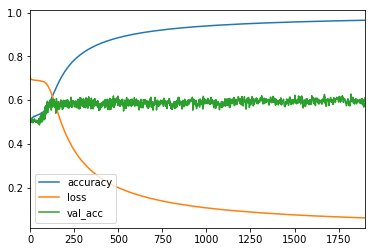

In [16]:
%matplotlib inline
ax = df_metrics.plot()
fig = ax.figure
fig.savefig('plots/siam-'+str(imgDim)+'-cnn-'+mode+'-plot-cnn.png')

[[  1.00000000e+00   3.49282594e-08]
 [  5.33774436e-01   4.66225564e-01]
 [  4.80640338e-05   9.99951959e-01]
 [  9.99696255e-01   3.03758075e-04]
 [  9.97020423e-01   2.97953910e-03]]


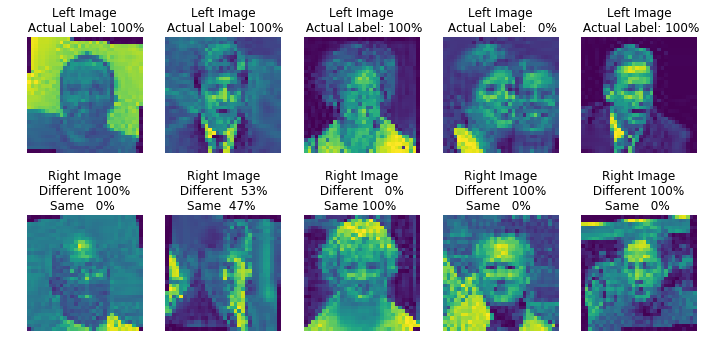

In [17]:
# similarity_model = load model (best one)
%matplotlib inline
def show_model_output(nb_examples = 5):
    
#     pv_a, pv_b,pv_s_l,pv_s_r, pv_sim = gen_random_val_batch(nb_examples)
    pv_a, pv_b, pv_sim = gen_random_val_batch(nb_examples)
#     pred_sim = similarity_model.predict([pv_a, pv_b,pv_s_l,pv_s_r])
    pred_sim = similarity_model.predict([pv_a, pv_b])
    p_val_argmax=[]
    print(pred_sim)
    for p in pred_sim:
        p_val_argmax.append(np.argmax(p))
    p_val_argmax = np.array(p_val_argmax)
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Left Image\n Actual Label: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Right Image\n Different %3.0f%% \nSame %3.0f%% ' % (100*p_d[0],100*p_d[1]))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
v_left_image ,v_right_image, v_y = gen_random_val_batch(100)
pred_sim = similarity_model.predict([v_left_image ,v_right_image])
(pred_sim.round().astype('int')==v_y).sum()

In [ ]:
cat_v_y = to_categorical(v_y)
similarity_model.evaluate([v_left_image ,v_right_image],y=cat_v_y, batch_size=32, verbose=1)

In [ ]:
l,r,y = gen_random_train_batch(3)

In [ ]:
v_left_image.shape

In [ ]:
import random
random.sample(range(1, 10), 3)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(feat, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
SVG(model_to_dot(similarity_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
batch_metrics

In [ ]:
a = np.array([1,1,1,1,1,1,1,1,0])
b = np.array([1,1,1,1,1,1,1,1,0,0])
(a==b).sum()

In [ ]:
l,r,s,y = gen_random_val_batch_sift(1)

In [ ]:
s.shape

In [ ]:
feat.summary()